# Group: CopyPaste
#### Dataset used: Dataset_Hospital_Vists.csv, test.csv
#### Participants: Ligia, Gina, Raza

### Contents Draft

1. Problem and Goal Definition
2. Data Understanding
3. Data Quality Check
4. Exploratory Data Analysis
5. Data Cleaning and Preprocessing
6. Train-Test Split
7. Model Building
8. Model Evaluation
9. Model Interpretation
10. Fine-Tuning and Optimization

### 1. Problem and Goal Definition
Problem: Patients in a hospital miss their scheduled appointments.

Goal: Develop a machine learning model that predicts if a patient will miss a future appointment.

### 2. Data Understanding
#### 2.1 Dataset Description

- The dataset is at appointment level granularity and contains detail of each appointment and patient.

- It has 14 columns of which 1 will be our target variable: No-show.

- We mostly have information about an appointment's date and place and the patients' health details. A column also shows if a patient received an SMS before the appointment.

#### 2.2 Quick Analysis from Kaggle

- There is missing data in the columns Age, Community, Social Welfare, and some diseases.
- Female to Male ratio is 65:35.
- We have no NULLs in the target variable.
- For Handcap, we have multiple values even though it seems to be a binary variable.

### 3. Data Quality Check

- Uniqueness
- Missing data
- Data type consistency check
- Distribution of Categorical Variables
- Dates inconsistency

In [159]:
# Setting up environment with packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [160]:
# Importing the dataset

df = pd.read_csv("/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/Dataset_Hospital_Visits.csv")
df.head()

# Increase seaborn default resolution
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(5,6)})

# Give variables to color numbers

green = '#008000'
red = '#ff0000'


In [161]:
## Uniqueness

# Is each row unique?

print("Duplicate rows: " + str(df.duplicated().sum()))

# Is each appointmentID unique?

print("Duplicate appointments: " + str(df['AppointmentID'].duplicated().sum()))

Duplicate rows: 0
Duplicate appointments: 0


We can conclude that the dataset only containts unique IDs and no duplicates.

In [162]:
## Missing Data

# Which columns have missing data?

missing_data = df.isnull().sum()
total_entries = len(df)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       8807                9.96
Community                10713               12.12
SocialWelfare            12519               14.16
Hipertension              8021                9.07
Diabetes                     0                0.00
Alcoholism               14889               16.84
Handcap                      0                0.00
SMS_received                 0                0.00
No-show                      0                0.00


As seen from Kaggle, Age, Community, SocialWelfare, Hipertension, and Alcoholism have significant null values.

In [163]:
## Data Type Consistency

df.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

1. PatientId and Age are to be converted to int from float as IDs must be int/str and ages are usually considered in whole number terms.
2. ScheduledDate and AppointmentDate must be timestamps and not objects.

In [164]:
# Distribution of Categorical Variables

occ = df.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0       2    139
1       3     11
2       4      3
3      no  86626
4     yes   1642


We assume that this column was meant to be a binary column and the numerical values are bad data. They will be removed during data cleaning.

In [165]:
# Dates inconsistency

from datetime import datetime

df['AppointmentDate'] = df['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df['ScheduledDate'] = df['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

counts = df['ScheduledDate'] > df['AppointmentDate']
occurrence_counts = counts.value_counts()

print(occurrence_counts)

False    88417
True         4
Name: count, dtype: int64


We see that we have 4 incoherent combination of schedule and appointment dates - they will be taken out in data cleaning stage.

### 4. Exploratory Data Analysis

- Distribution of the target variable.
- Distribution of age. Which age groups account for the most missing appointments?
- Do patients of a certain community miss their appointments more than others?
- Do males or females miss more appointments?

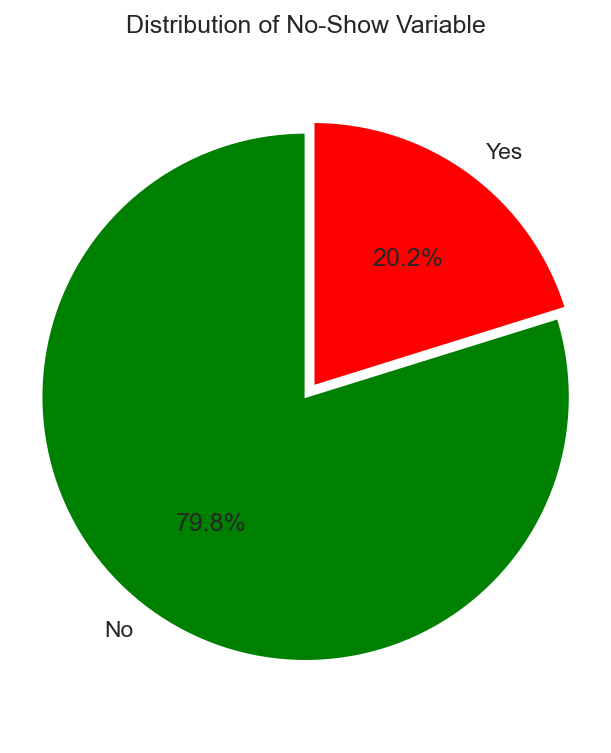

In [166]:
## Distribution of the target variable

value_counts = df['No-show'].value_counts()

labels = value_counts.index
sizes = value_counts.values

colors = [green,red]  # Customize colors
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

plt.title('Distribution of No-Show Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.show()

1 in 5 appointments are missed on average.

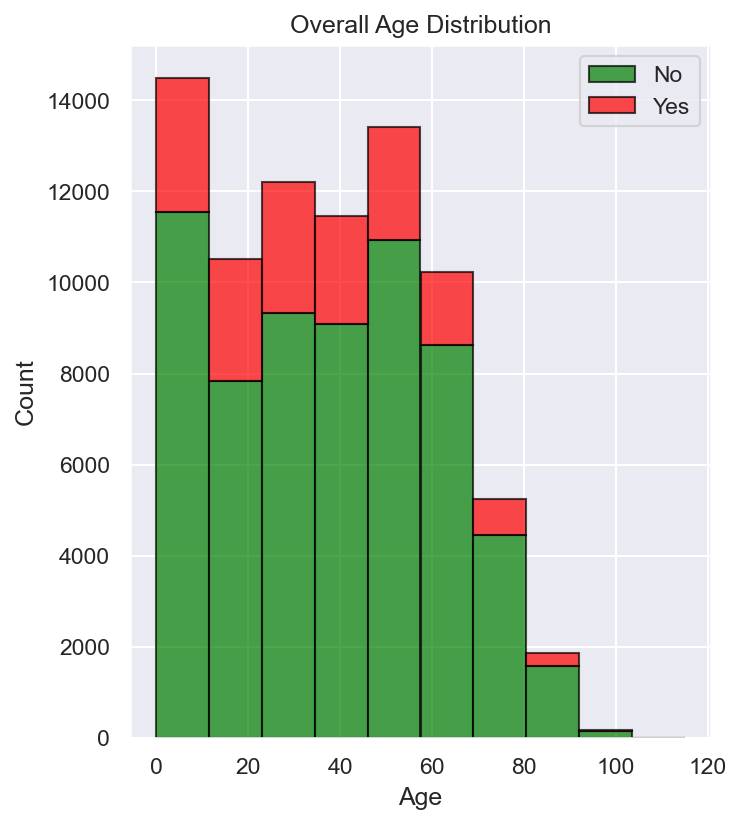

In [167]:
# Which age group misses more appointments?

# Plot histogram with split bars

plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# To add % later:

# n, bins, _ = plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
#          bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

# for i in range(len(bins) - 1):
#     total = n[0][i] + n[1][i]
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[0][i] / total:.0%}', ha='center', va='bottom')
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[1][i] / total:.0%}', ha='center', va='top')

plt.show()

There is an even distribution of the ratio of appointments missed in the various age groups. This tends to change after age 70 where appointments are missed a lot less.

This could be explained by the fact that older people cannot afford to miss appointments due to more serious health issues and due to the fact that they might have more time on their hand.

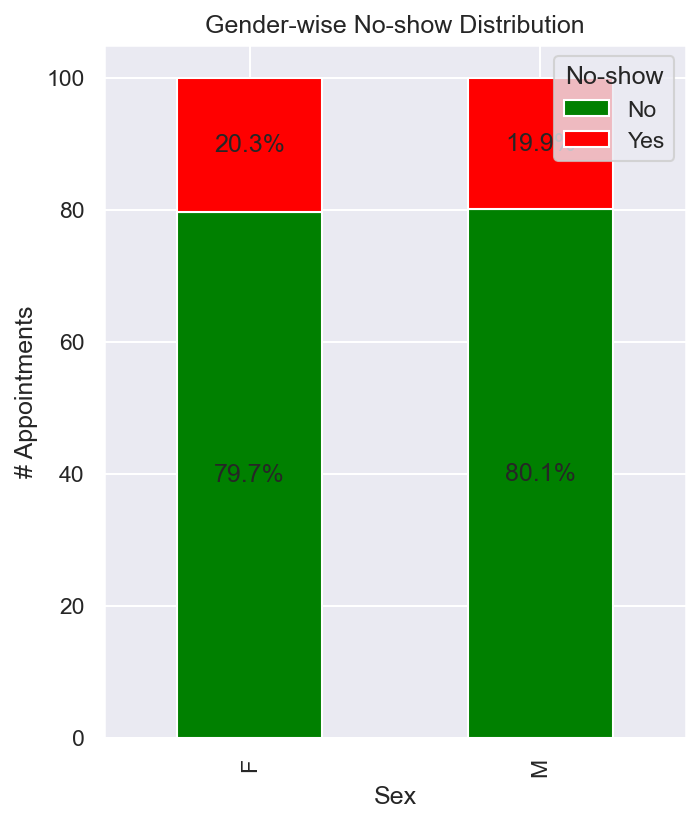

In [168]:
## Which gender misses more appointments?

# Group by 'gender' and 'no_show' and count occurrences
grouped_data = df.groupby(['Sex', 'No-show']).size().unstack()

# Calculate percentages
percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting a grouped bar chart
ax = percentages.plot(kind='bar', stacked=True, color=[green, red])

# Annotate bars with percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Gender-wise No-show Distribution')
plt.xlabel('Sex')
plt.ylabel('# Appointments')
plt.legend(title='No-show', loc='upper right')

plt.show()

There seems to be 1 in 5 appointments missed for both genders.

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/2128642182.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)


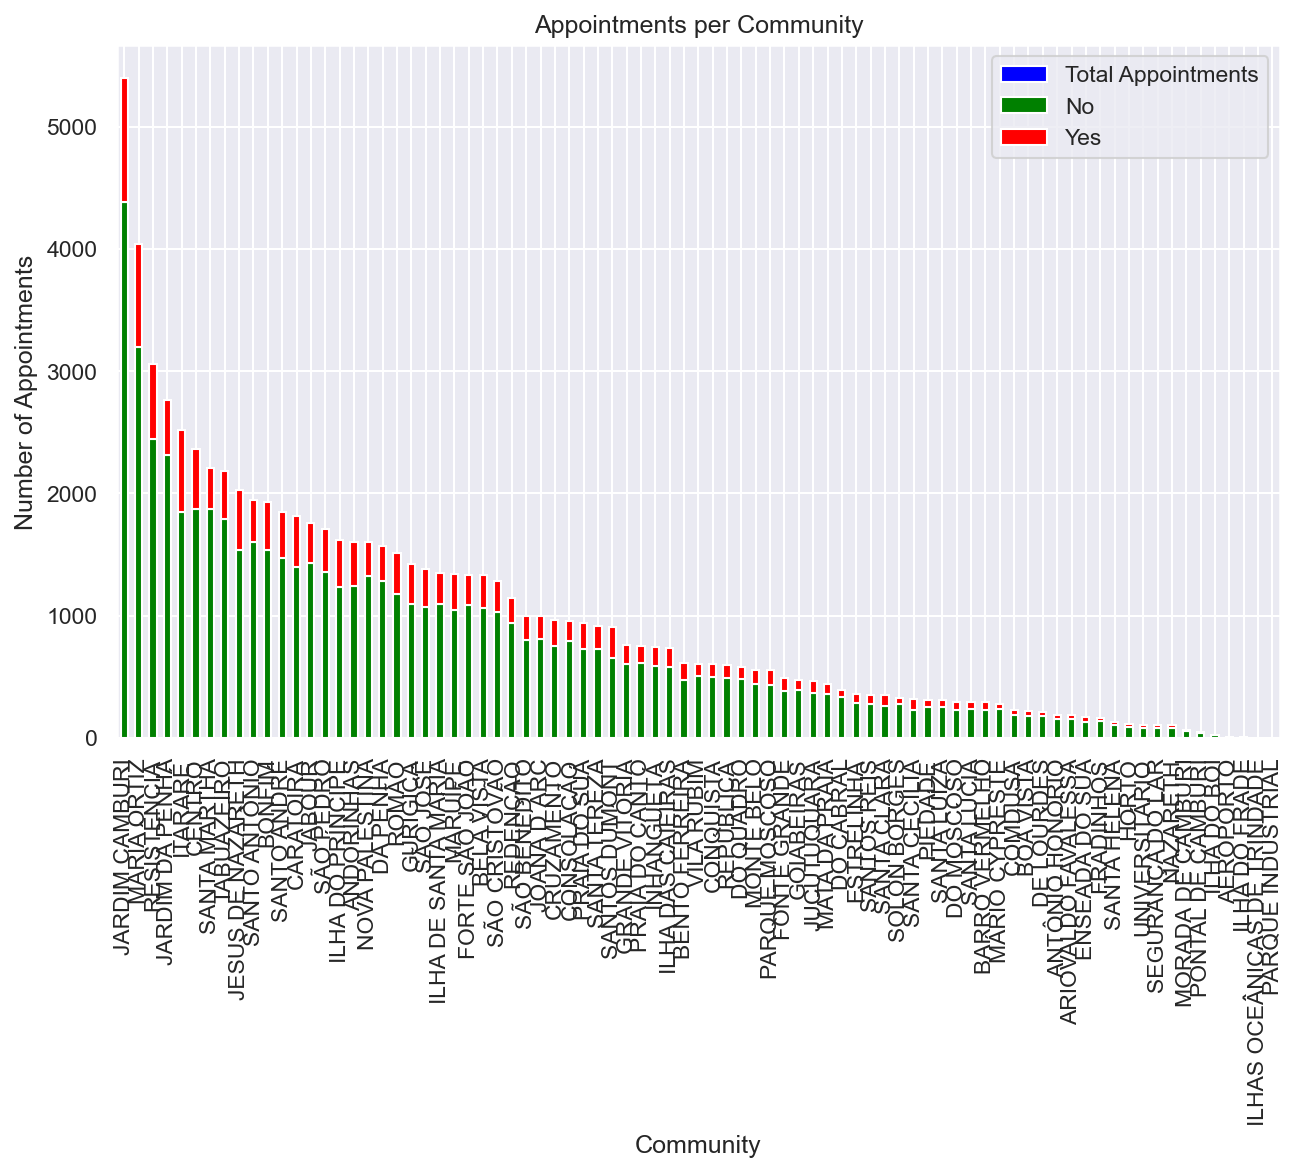

In [169]:

# Do patients of a certain community miss their appointments more than others?

# Count the total number of appointments per community
total_appointments_per_community = df['Community'].value_counts()

# Sort the DataFrame based on the total number of appointments
sorted_df = df[df['Community'].isin(total_appointments_per_community.index)].copy()
sorted_df['Community'] = pd.Categorical(sorted_df['Community'], categories=total_appointments_per_community.index, ordered=True)
sorted_df = sorted_df.sort_values(by=['Community'])

# Count the number of appointments per community split by show_up status
appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for total appointments per community
total_appointments_per_community.loc[sorted_df['Community'].unique()].plot(kind='bar', ax=ax, color='blue', label='Total Appointments')

# Bar chart for appointments per community split by show_up status
appointments_per_community_show_up.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'], label=['Show Up', 'No Show Up'])

# Adding labels and legend
ax.set_title('Appointments per Community')
ax.set_xlabel('Community')
ax.set_ylabel('Number of Appointments')
ax.legend()

plt.show()

### 5. Data Cleaning and Basic Preprocessing
- Dropping erroneous data
- Substituting illogical entries in Handicap column
- Extrapolating data for each patient where exists
- Time between ScheduledDate and AppointmentDate
- Standardization of Continuous variable

In [170]:
# Keeping original df intact

df_t = df[:]

In [171]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88421 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88421 non-null  float64
 1   AppointmentID    88421 non-null  int64  
 2   Sex              88421 non-null  object 
 3   ScheduledDate    88421 non-null  object 
 4   AppointmentDate  88421 non-null  object 
 5   Age              79614 non-null  float64
 6   Community        77708 non-null  object 
 7   SocialWelfare    75902 non-null  object 
 8   Hipertension     80400 non-null  object 
 9   Diabetes         88421 non-null  object 
 10  Alcoholism       73532 non-null  object 
 11  Handcap          88421 non-null  object 
 12  SMS_received     88421 non-null  object 
 13  No-show          88421 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.4+ MB


In [172]:
## Data Type Consistency

df_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

In [173]:
# Dropping erroneous data

# Dropping inconsistent dates from transformed dataframe

df_t = df_t.drop(df[df['ScheduledDate'] > df['AppointmentDate']].index)

In [174]:
# Assuming that the number is the number of handicaps

df_t.loc[df_t['Handcap'].isin(['2','3','4']), 'Handcap'] = 'yes'
df_t.info()
occ = df_t.groupby('Handcap').size().reset_index()
print(occ)

<class 'pandas.core.frame.DataFrame'>
Index: 88417 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88417 non-null  float64
 1   AppointmentID    88417 non-null  int64  
 2   Sex              88417 non-null  object 
 3   ScheduledDate    88417 non-null  object 
 4   AppointmentDate  88417 non-null  object 
 5   Age              79611 non-null  float64
 6   Community        77704 non-null  object 
 7   SocialWelfare    75899 non-null  object 
 8   Hipertension     80396 non-null  object 
 9   Diabetes         88417 non-null  object 
 10  Alcoholism       73529 non-null  object 
 11  Handcap          88417 non-null  object 
 12  SMS_received     88417 non-null  object 
 13  No-show          88417 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 10.1+ MB
  Handcap      0
0      no  86623
1     yes   1794


In [175]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/699699711.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [176]:

# Adding New Feature: Time between ScheduledDate and AppointmentDate

from datetime import timedelta

df_t['time_bw_schedule_appointment'] = df_t['AppointmentDate'] - df_t['ScheduledDate']

## Convert to float (days)

df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'].astype(float)

In [177]:
# Capitalising yes/no so they can be converted to binary column

df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)
missing_data = df_t.isnull().sum()
total_entries = len(df_t)
percentage_missing = round((missing_data / total_entries) * 100, 2)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/17146736.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [178]:
# Missing Data

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                              Missing Count  Percentage Missing
PatientId                                 0                0.00
AppointmentID                             0                0.00
Sex                                       0                0.00
ScheduledDate                             0                0.00
AppointmentDate                           0                0.00
Age                                    3778                4.27
Community                              4631                5.24
SocialWelfare                          5450                6.16
Hipertension                           3406                3.85
Diabetes                                  0                0.00
Alcoholism                             6611                7.48
Handcap                                   0                0.00
SMS_received                              0                0.00
No-show                                   0                0.00
time_bw_schedule_appointment            

### 6. Train-Test Split

In [179]:
from sklearn.model_selection import train_test_split

# Avoiding Target Leakage by ensuring each patient is only in one dataset.

unique_patient_ids = df_t['PatientId'].unique()

# Splitting into test and train set.
patients_train, patients_test = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)

# Removing some columns because do not need them anymore: both date columns as we have the difference now.

columns_to_drop = ["PatientId", "No-show", "AppointmentID", "ScheduledDate", "AppointmentDate"]

X_train = df_t[df_t['PatientId'].isin(patients_train)].drop(columns_to_drop, axis=1)
y_train = df_t[df_t['PatientId'].isin(patients_train)]["No-show"]

X_test = df_t[df_t['PatientId'].isin(patients_test)].drop(columns_to_drop, axis=1)
y_test = df_t[df_t['PatientId'].isin(patients_test)]["No-show"]

In [180]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 61652 entries, 0 to 88419
Series name: No-show
Non-Null Count  Dtype 
--------------  ----- 
61652 non-null  object
dtypes: object(1)
memory usage: 963.3+ KB


In [181]:
## Checking Target variable in both groups
train_counts = y_train.value_counts(normalize=True) * 100
train_counts

No-show
No     79.827094
Yes    20.172906
Name: proportion, dtype: float64

In [182]:
## Checking Target variable in both groups
test_counts = y_test.value_counts(normalize=True) * 100
test_counts

No-show
No     79.77209
Yes    20.22791
Name: proportion, dtype: float64

In [183]:
X_train.head()

,Sex,Age,Community,SocialWelfare,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,time_bw_schedule_appointment
0,F,24.0,Resistência,No,No,No,No,No,No,79.0
2,F,19.0,Jardim da penha,No,No,No,No,No,No,0.0
3,F,55.0,Jesus de nazareth,No,Yes,No,No,No,No,0.0
5,F,51.0,Maruípe,No,Yes,No,No,No,Yes,13.0
8,F,NaN,Santos dumont,NaN,No,No,No,No,No,1.0


### 7. Advanced Data Preprocessing
- Handling remaining missing Data: Extrapolation + Imputation
- OneHotEncoding for Categorical Vairables
- Feature Selection based on Correlation Matrix
- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [184]:
# Dealing with missing values via imputation

from sklearn.impute import SimpleImputer

median_imp = SimpleImputer(strategy='median', add_indicator=False)
mode_imp = SimpleImputer(strategy='most_frequent', add_indicator=False)

In [185]:
# One Hot Encoding of Categorical Variables

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Separate columns into numeric and categorical
numeric_features = ['Age', "time_bw_schedule_appointment"]
categorical_features = ['SocialWelfare', 'Diabetes', 'Sex', 'Alcoholism', 'Hipertension', 'SMS_received', 'Handcap', "Community"]

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', median_imp)
])

categorical_transformer = Pipeline(steps=[
    
    ('imputer', mode_imp),
    ('onehot', ohe)
])

# Apply transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

transformed_train = preprocessor.fit_transform(X_train)

In [187]:
# Confirming we have no remaining missing values in X_train

columns = preprocessor.get_feature_names_out()
transformed_train = pd.DataFrame(transformed_train, columns=columns)
transformed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61652 entries, 0 to 61651
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   numeric__Age                                        61652 non-null  float64
 1   numeric__time_bw_schedule_appointment               61652 non-null  float64
 2   categorical__SocialWelfare_Yes                      61652 non-null  float64
 3   categorical__Diabetes_Yes                           61652 non-null  float64
 4   categorical__Sex_M                                  61652 non-null  float64
 5   categorical__Alcoholism_Yes                         61652 non-null  float64
 6   categorical__Hipertension_Yes                       61652 non-null  float64
 7   categorical__SMS_received_Yes                       61652 non-null  float64
 8   categorical__Handcap_Yes                            61652 non-null  float64


In [188]:
# Confirming we have no remaining missing values in X_test

transformed_test = preprocessor.fit_transform(X_test)
transformed_test = pd.DataFrame(transformed_test)
transformed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26765 entries, 0 to 26764
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       26765 non-null  float64
 1   1       26765 non-null  float64
 2   2       26765 non-null  float64
 3   3       26765 non-null  float64
 4   4       26765 non-null  float64
 5   5       26765 non-null  float64
 6   6       26765 non-null  float64
 7   7       26765 non-null  float64
 8   8       26765 non-null  float64
 9   9       26765 non-null  float64
 10  10      26765 non-null  float64
 11  11      26765 non-null  float64
 12  12      26765 non-null  float64
 13  13      26765 non-null  float64
 14  14      26765 non-null  float64
 15  15      26765 non-null  float64
 16  16      26765 non-null  float64
 17  17      26765 non-null  float64
 18  18      26765 non-null  float64
 19  19      26765 non-null  float64
 20  20      26765 non-null  float64
 21  21      26765 non-null  float64
 22

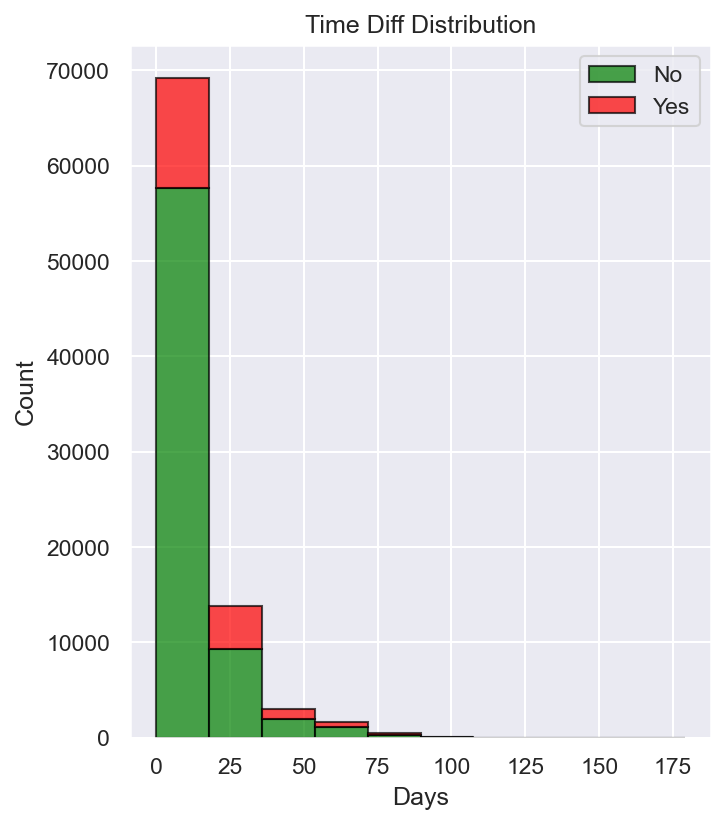

In [189]:
# Plot histogram with split bars ## EDA and can be removed later.

plt.hist([df_t[df_t['No-show'] == 'No']['time_bw_schedule_appointment'], df_t[df_t['No-show'] == 'Yes']['time_bw_schedule_appointment']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Time Diff Distribution')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()

plt.show()

In [190]:
y_train.info()
transformed_train.info()

<class 'pandas.core.series.Series'>
Index: 61652 entries, 0 to 88419
Series name: No-show
Non-Null Count  Dtype 
--------------  ----- 
61652 non-null  object
dtypes: object(1)
memory usage: 963.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61652 entries, 0 to 61651
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   numeric__Age                                        61652 non-null  float64
 1   numeric__time_bw_schedule_appointment               61652 non-null  float64
 2   categorical__SocialWelfare_Yes                      61652 non-null  float64
 3   categorical__Diabetes_Yes                           61652 non-null  float64
 4   categorical__Sex_M                                  61652 non-null  float64
 5   categorical__Alcoholism_Yes                         61652 non-null  float64
 6   categorical__Hipertension_Yes        


### 7.2 Feature Selection
- Feature Selection based on Correlation Matrix
- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [191]:
## Concatenating X_train and y_train for feature selection

transformed_train = transformed_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

df_feature_selection = pd.concat([transformed_train, y_train], axis = 1)

In [192]:
df_feature_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61652 entries, 0 to 61651
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   numeric__Age                                        61652 non-null  float64
 1   numeric__time_bw_schedule_appointment               61652 non-null  float64
 2   categorical__SocialWelfare_Yes                      61652 non-null  float64
 3   categorical__Diabetes_Yes                           61652 non-null  float64
 4   categorical__Sex_M                                  61652 non-null  float64
 5   categorical__Alcoholism_Yes                         61652 non-null  float64
 6   categorical__Hipertension_Yes                       61652 non-null  float64
 7   categorical__SMS_received_Yes                       61652 non-null  float64
 8   categorical__Handcap_Yes                            61652 non-null  float64


<Axes: >

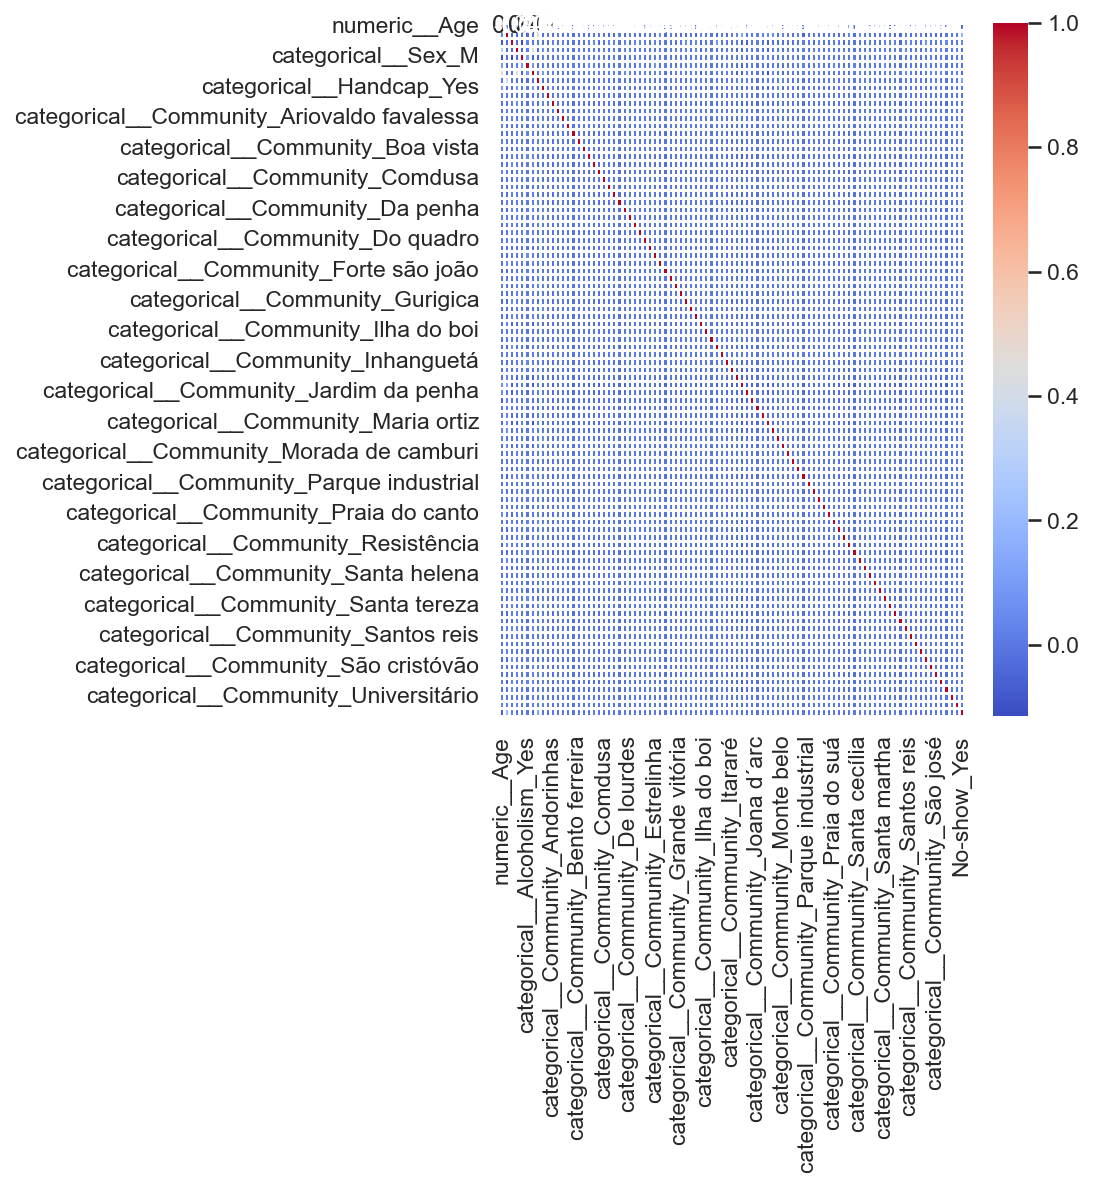

In [193]:
# Feature Selection: Correlation Matrix to understand which features have highest correlation with target variable and less correlation amongst each other.

df_t_encoded = pd.get_dummies(df_feature_selection, columns=['No-show'], drop_first=True).astype(int)

correlation_matrix = df_t_encoded.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

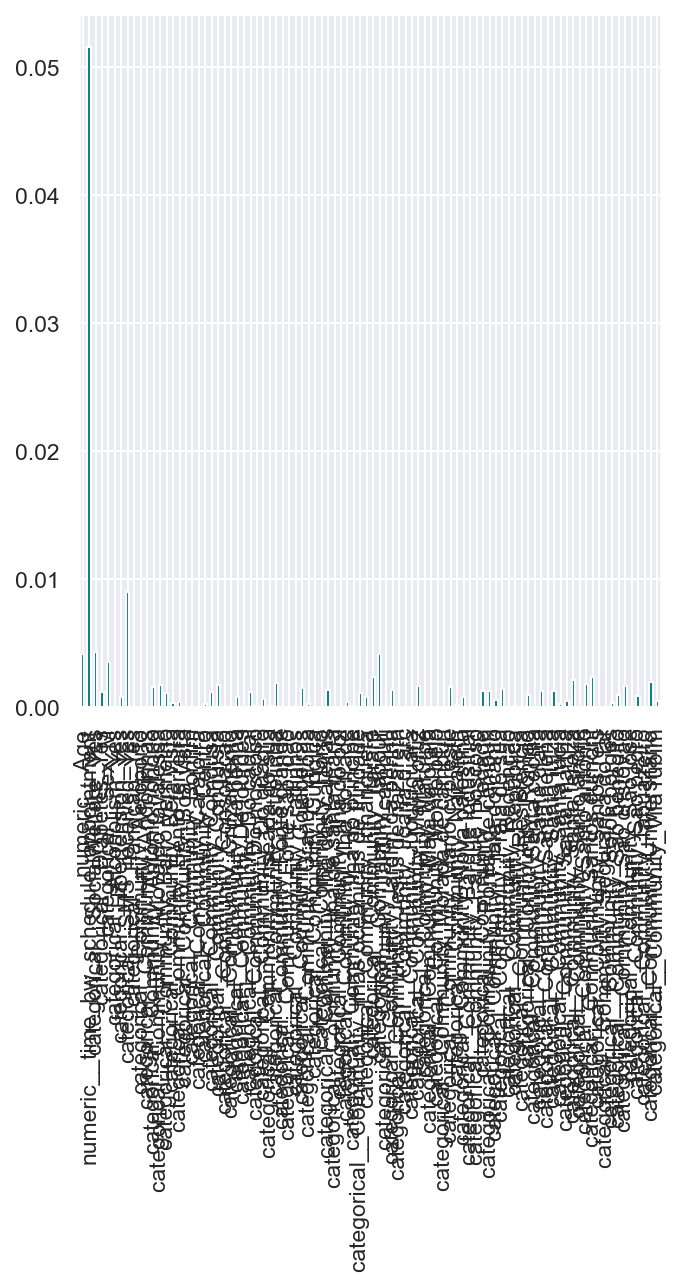

In [194]:
# Feature Selection based on Info Gain

from sklearn.feature_selection import mutual_info_classif

X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, df_t_encoded.columns[0:len(df_t_encoded.columns)-1])
feature_importances.plot(kind="bar", color="teal")
plt.show()

In [195]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from numpy import array

# Create training set and prediction target
X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

# Perform feature selection
# Set k to the number of features you want to identify
select = SelectKBest(score_func=f_classif, k=4)
select.fit_transform(X,y)

# Print feature names
filter = select.get_support() 
features = array(X.columns)
 
print("Selected best:")
print(features[filter])

Selected best:
['numeric__Age' 'numeric__time_bw_schedule_appointment'
 'categorical__Hipertension_Yes' 'categorical__SMS_received_Yes']


### 8. Model Building


#### 8.1 Decision Tree

In [196]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()

# Create pipeline
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)]
)

In [197]:
pipe_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Diabetes',
                                                   'Sex', 'Alcoholism',
                                                   'Hipertension',
                                                   'SMS_received', 'Handcap',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [198]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Diabetes',
                                                   'Sex', 'Alcoholism',
                                                   'Hipertension',
                                                   'SMS_received', 'Handcap',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [199]:
y_pred = pipe_dt.predict(X_test)

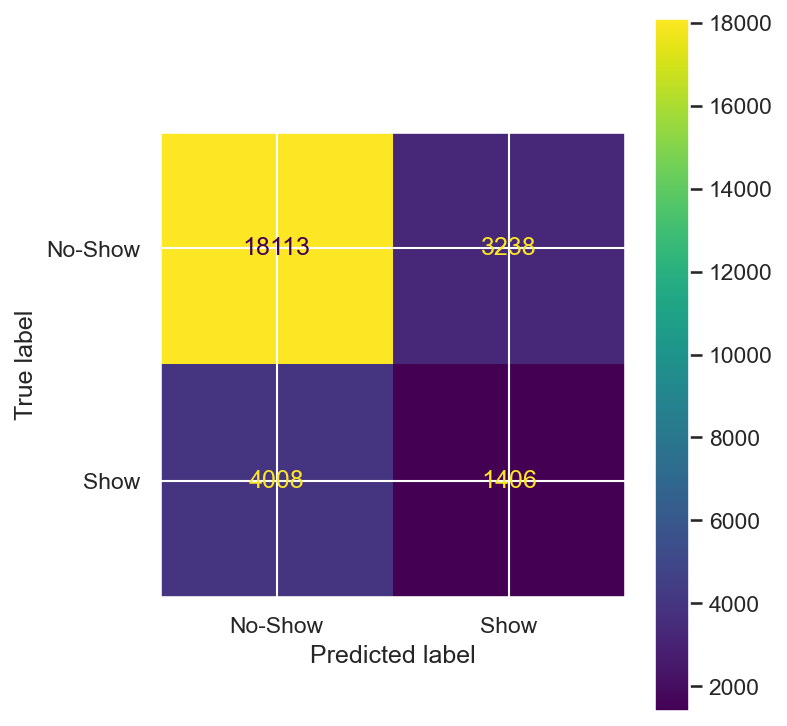

In [200]:
# Evaluating the model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [201]:
# Print a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.85      0.83     21351
         Yes       0.30      0.26      0.28      5414

    accuracy                           0.73     26765
   macro avg       0.56      0.55      0.56     26765
weighted avg       0.71      0.73      0.72     26765



#### 8.2 XGBOOST

In [202]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 61652 entries, 0 to 61651
Series name: No-show
Non-Null Count  Dtype 
--------------  ----- 
61652 non-null  object
dtypes: object(1)
memory usage: 481.8+ KB


In [203]:
# Encoding y train and y test to binary

mapping = {'No': 0, 'Yes': 1}
y_train = y_train.replace(mapping)
y_test = y_test.replace(mapping)

In [204]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 61652 entries, 0 to 61651
Series name: No-show
Non-Null Count  Dtype
--------------  -----
61652 non-null  int64
dtypes: int64(1)
memory usage: 481.8 KB


In [205]:
from xgboost import XGBClassifier

# Giving more weight to the minority class

num_positive_instances = np.sum(y_train == 1)
num_negative_instances = np.sum(y_train == 0)

imbalance_ratio = num_negative_instances / num_positive_instances

xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight = imbalance_ratio)

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)]
)

pipe_xgb.fit(X_train, y_train)

preds_xgb = pipe_xgb.predict(X_test)

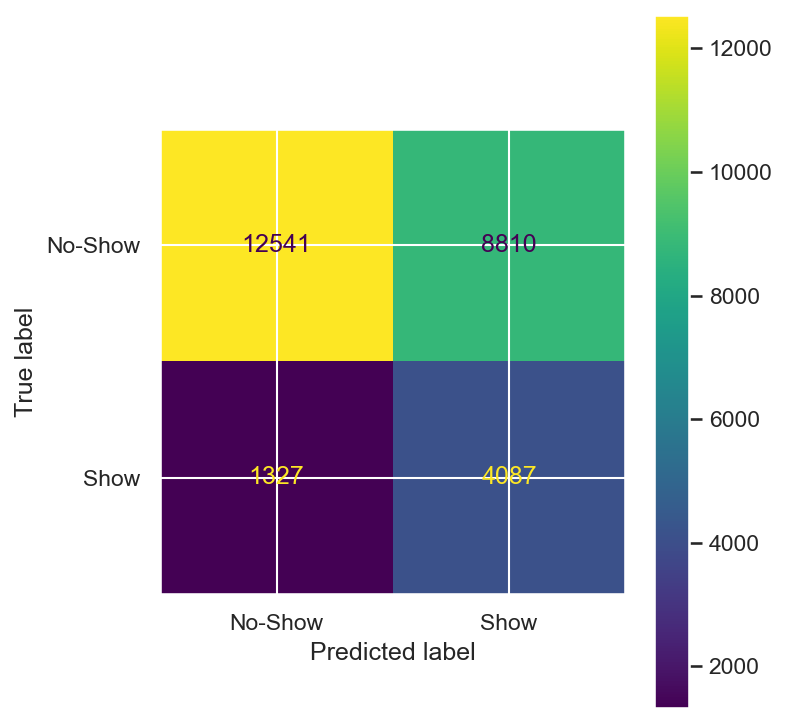

In [206]:
display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, preds_xgb, labels=pipe_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [207]:
## part of xg boost

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.90      0.59      0.71     21351
           1       0.32      0.75      0.45      5414

    accuracy                           0.62     26765
   macro avg       0.61      0.67      0.58     26765
weighted avg       0.79      0.62      0.66     26765



#### 8.3 RANDOM FOREST

In [208]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(n_estimators=50, random_state=42)

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)]
)

pipe_rf.fit(X_train, y_train)

preds_rf = pipe_rf.predict(X_test)
preds_rf

array([0, 0, 0, ..., 1, 0, 0])

#### 8.4 Logistic Regression

In [234]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(class_weight = 'balanced')

pipe_lgr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgr)]
)

pipe_lgr.fit(X_train, y_train)

preds_lgr = pipe_lgr.predict(X_test)
preds_lgr

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 1, 1, ..., 1, 0, 0])

#### 8.5 Support Vector Machines

In [247]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, class_weight='balanced')

pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm)]
)

pipe_svm.fit(X_train, y_train)

preds_svm = pipe_svm.predict(X_test)
preds_svm

#### 8.5 Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

svc = VotingClassifier(estimators=[('dt', clf), ('xgb', xgb), ('rf', rf), ('lgr', lgr), ('svm', svm)], voting='soft')
hvc = VotingClassifier(estimators=[('dt', clf), ('xgb', xgb), ('rf', rf)], voting='hard')

pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svc)]
)

pipe_hvc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', hvc)]
)


In [ ]:
pipe_svc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Diabet...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=50,
                                                                      random_state=42)),
                                              ('lgr',
                                               LogisticRegression(class_weight='balanced'))],
                                  voting='soft'))])

In [211]:
# # Evaluate the classifiers

# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score

# hard_voting_pred = pipe_hvc.predict(X_test)
# soft_voting_pred = pipe_svc.predict(X_test)

# print("F1 with Hard Voting:", f1_score(y_test, hard_voting_pred))
# print("F1 with Soft Voting:", f1_score(y_test, soft_voting_pred))
# print("Accuracy with Hard Voting:", precision_score(y_test, hard_voting_pred))
# print("Accuracy with Soft Voting:", precision_score(y_test, soft_voting_pred))
# print("Accuracy with Hard Voting:", recall_score(y_test, hard_voting_pred))
# print("Accuracy with Soft Voting:", recall_score(y_test, soft_voting_pred))

F1 with Hard Voting: 0.30966239813736907
F1 with Soft Voting: 0.2950168751240818
Accuracy with Hard Voting: 0.3261136085002043
Accuracy with Soft Voting: 0.31888412017167383
Accuracy with Hard Voting: 0.29479128186183967
Accuracy with Soft Voting: 0.2744735869966753


### 9. Model Evaluation

#### 9.1 Preprocessing test.cv

In [238]:
# Keeping original df_test intact:

df_test = pd.read_csv('/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/test.csv')

df_test_t = df_test[:]

In [213]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


In [214]:
## Data Type Consistency

df_test_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
dtype: object

In [215]:
from datetime import datetime

df_test_t['AppointmentDate'] = df_test_t['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df_test_t['ScheduledDate'] = df_test_t['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

In [216]:
# Dropping erroneous data

# Dropping inconsistent dates from transformed dataframe

# df_test_t = df_test_t.drop(df_test[df_test['ScheduledDate'] > df_test['AppointmentDate']].index)

In [217]:
# Dropping outliers for Handcap: 2, 3, 4

import numpy as np

df_test_t.loc[df_test_t['Handcap'].isin(['2', '3', '4']), 'Handcap'] = 'yes'
df_test_t.info()
occ_test = df_test_t.groupby('Handcap').size().reset_index()
print(occ_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB
  Handcap      0
0      no  21660
1     yes    446


In [218]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/1740001506.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [219]:

# Adding New Feature: Time between ScheduledDate and AppointmentDate

df_test_t['time_bw_schedule_appointment'] = df_test_t['AppointmentDate'] - df_test_t['ScheduledDate']

## Convert to float (days)

df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'].astype(float)

In [220]:
# Capitalising yes/no so they can be converted to binary column

df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/470778378.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [224]:
X_df_test = df_test_t.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDate', 'AppointmentDate'])

X_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           22106 non-null  object 
 1   Age                           20559 non-null  float64
 2   Community                     20131 non-null  object 
 3   SocialWelfare                 19805 non-null  object 
 4   Hipertension                  20625 non-null  object 
 5   Diabetes                      22106 non-null  object 
 6   Alcoholism                    19280 non-null  object 
 7   Handcap                       22106 non-null  object 
 8   SMS_received                  22106 non-null  object 
 9   time_bw_schedule_appointment  22106 non-null  float64
dtypes: float64(2), object(8)
memory usage: 1.7+ MB


In [225]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


### 9.2 Model Evaluation

In [239]:
y_pred_test = pipe_svc.predict(X_df_test)

In [240]:
df_test_t["No-show"] = y_pred_test

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/3168876947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_t["No-show"] = y_pred_test


In [241]:
mapping = {0: 'No', 1: 'Yes'}
df_test_t["No-show"] = df_test_t["No-show"].replace(mapping)
Submission = df_test_t[["AppointmentID", "No-show"]]
Submission.head()

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_82866/442777090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_t["No-show"] = df_test_t["No-show"].replace(mapping)


,AppointmentID,No-show
0,5620835,No
1,5741692,Yes
2,5673005,No
3,5579701,No
4,5652332,No


In [242]:
Submission = df_test_t[["AppointmentID", "No-show"]]
Submission.head()

,AppointmentID,No-show
0,5620835,No
1,5741692,Yes
2,5673005,No
3,5579701,No
4,5652332,No


In [243]:
filepath = '/Users/muhammadraza/Documents/GitHub/BIPM/Data Science/Project/Submission2.csv'
Submission.to_csv(filepath, index=False)

### 9. Model Interpretation


### 10. Fine-Tuning and Optimization